In [5]:
import os
import re
import sys
from os import listdir
from os.path import isfile, join
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np

from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [6]:
p_dir = (Path().cwd().parents[0]).absolute()

In [7]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import tof-sims data

In [8]:
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def get_imgs_SIMS(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
        fov = f[name].attrs["fov"]
    return imgs, labels, fov


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale


def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices


def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x, y]

    data = np.column_stack((x, y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)

    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0

    return img_fil

In [12]:
experiment = "cnms"

with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
    datasets = list(f.keys())
    print(datasets)

['B6_neg_1', 'B6_neg_2', 'B6_pos_1', 'B6_pos_2', 'C1_neg_1', 'C2_neg_1', 'C3_neg_1', 'C4_neg_1', 'C5_neg_1', 'C6_neg_1', 'E11_neg_1', 'E11_pos_1', 'E12_neg_1', 'E12_pos_1', 'G11_neg_1', 'G11_pos_1', 'G6_neg_1', 'G6_pos_1', 'H16_neg_1', 'H16_pos_1', 'J16_neg_1', 'J16_pos_1']


B6_neg_1


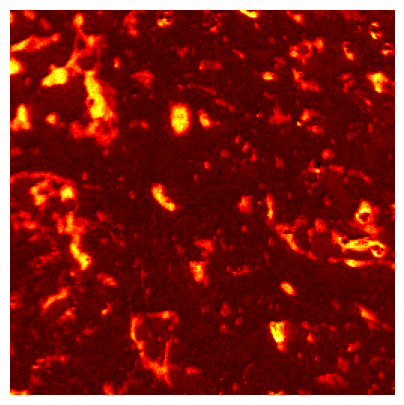

B6_neg_2


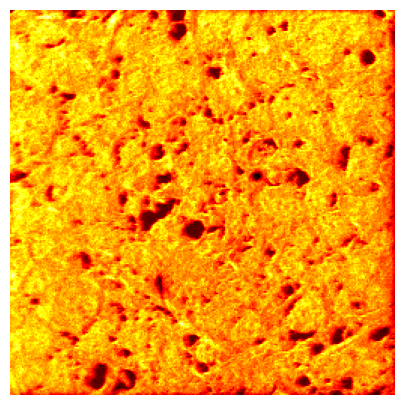

B6_pos_1


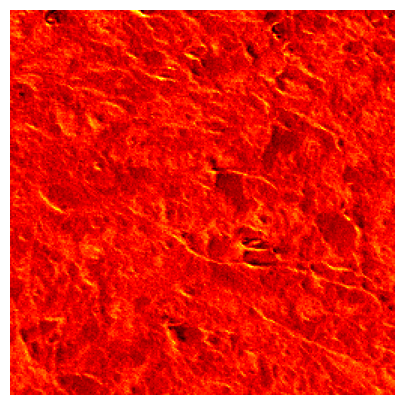

B6_pos_2


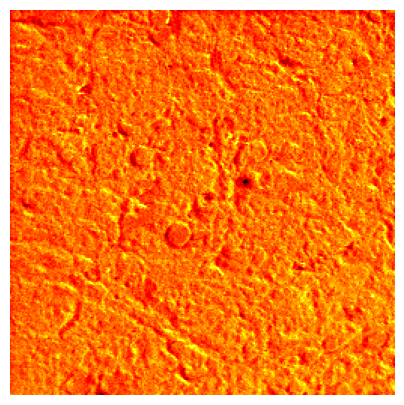

C1_neg_1


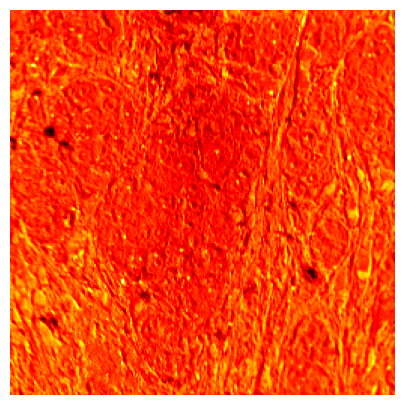

C2_neg_1


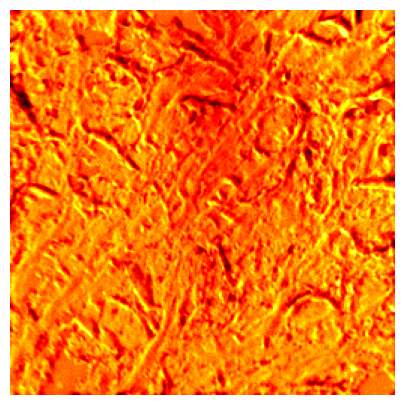

C3_neg_1


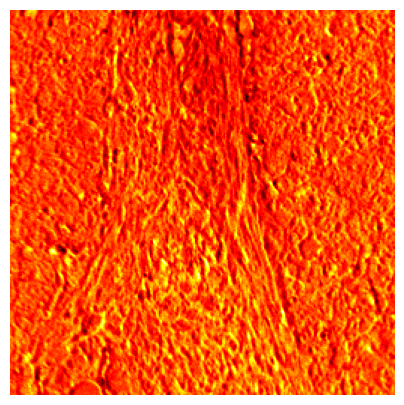

C4_neg_1


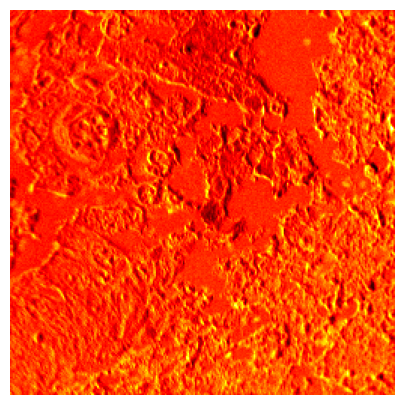

C5_neg_1


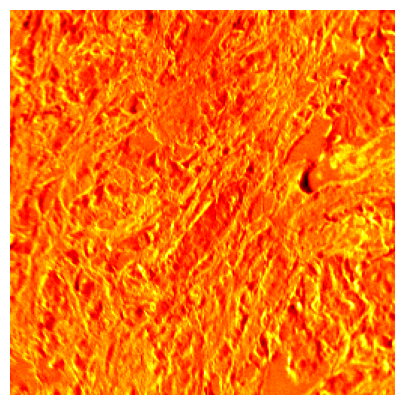

C6_neg_1


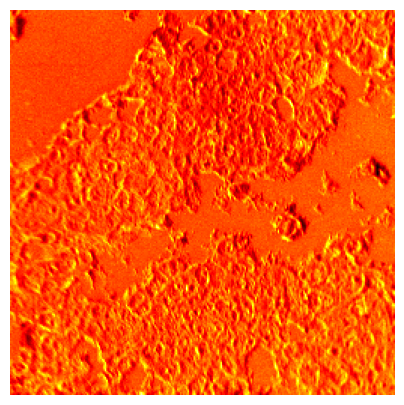

E11_neg_1


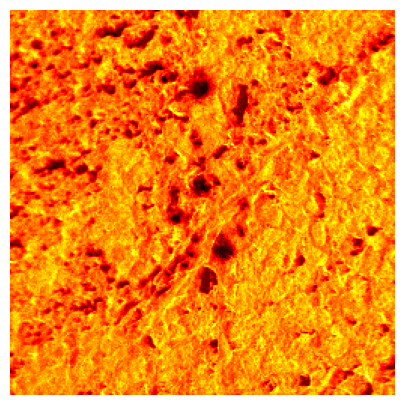

E11_pos_1


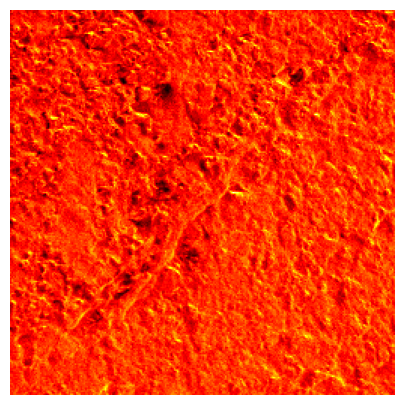

E12_neg_1


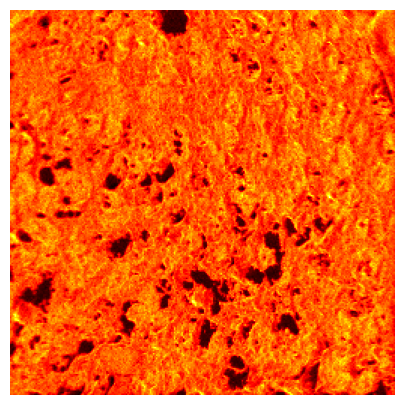

E12_pos_1


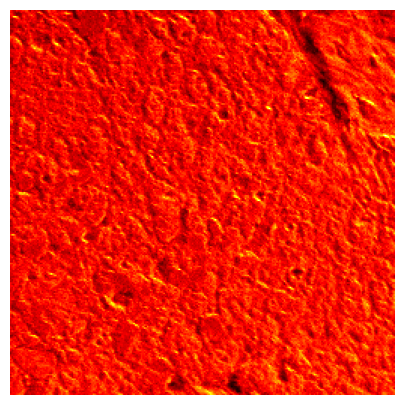

G11_neg_1


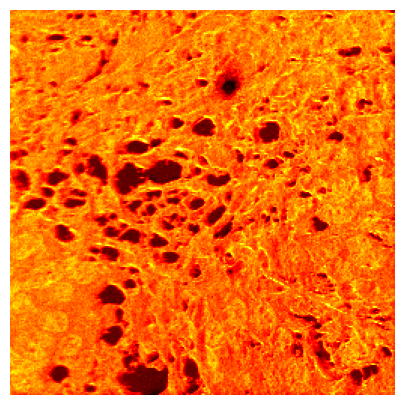

G11_pos_1


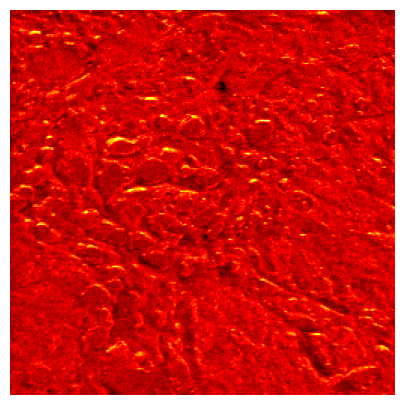

G6_neg_1


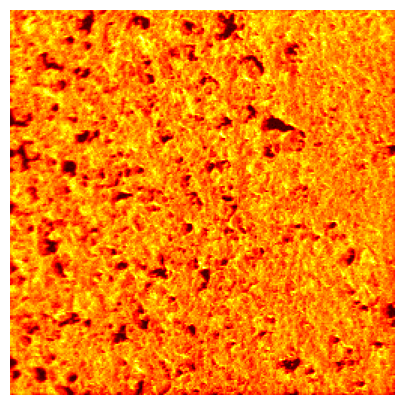

G6_pos_1


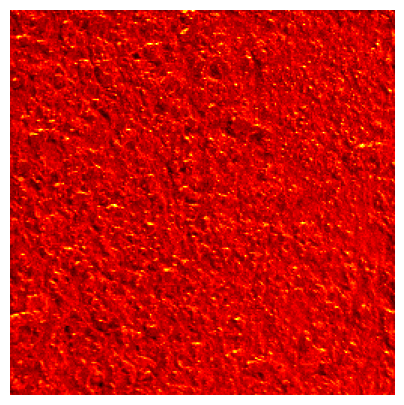

H16_neg_1


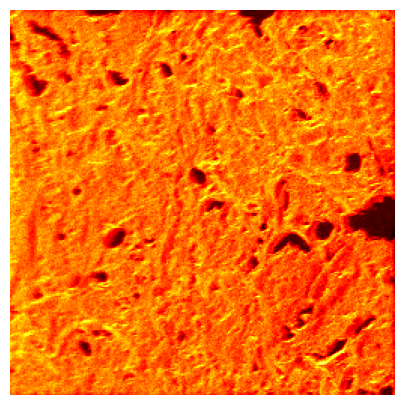

H16_pos_1


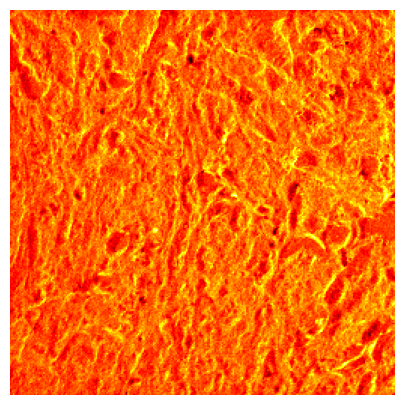

J16_neg_1


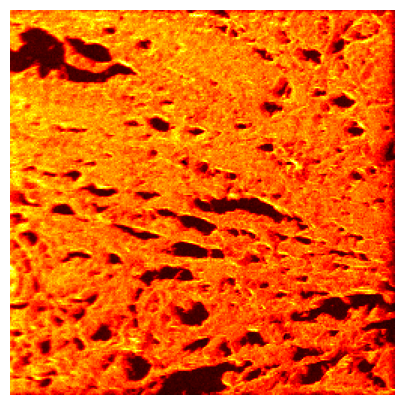

J16_pos_1


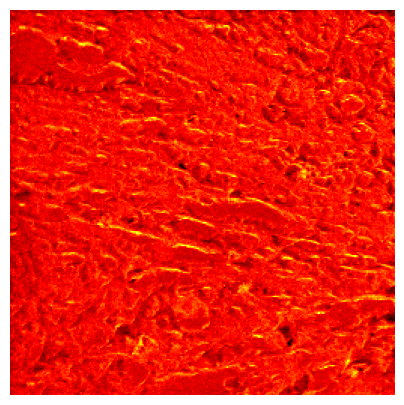

In [17]:
for i, name in enumerate(datasets):
    try:
        imgs, labels, fov = get_imgs_SIMS(experiment, name)
    except:
        continue
    print(name)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(imgs[0], cmap='hot')
    ax.axis('off')
    plt.show()

In [14]:
labels

['total',
 '1.00',
 '2.01',
 '11.98',
 '12.98',
 '13.99',
 '15.00',
 '15.97',
 '16.99',
 '18.02',
 '18.99',
 '19.95',
 '22.96',
 '23.94',
 '24.95',
 '25.97',
 '26.97',
 '27.95',
 '28.98',
 '30.00',
 '30.99',
 '32.02',
 '36.96',
 '37.96',
 '38.93',
 '39.92',
 '40.97',
 '41.99',
 '42.99',
 '43.99',
 '44.94',
 '45.93',
 '46.94',
 '47.92',
 '48.95',
 '49.94',
 '50.95',
 '51.96',
 '52.97',
 '53.98',
 '54.98',
 '55.99',
 '56.98',
 '58.00',
 '58.98',
 '60.00',
 '60.94',
 '61.93',
 '62.92',
 '63.94',
 '64.95',
 '65.94',
 '66.93',
 '67.97',
 '68.98',
 '70.01',
 '70.95',
 '71.91',
 '72.96',
 '73.98',
 '74.94',
 '75.94',
 '76.97',
 '77.92',
 '78.91',
 '79.97',
 '80.87',
 '81.97',
 '82.87',
 '83.99',
 '84.95',
 '85.98',
 '86.92',
 '87.88',
 '88.89',
 '89.89',
 '90.93',
 '91.91',
 '92.93',
 '93.95',
 '94.95',
 '95.94',
 '96.87',
 '97.97',
 '98.88',
 '99.96',
 '100.93',
 '101.94',
 '102.89',
 '103.88',
 '104.88',
 '105.89',
 '106.92',
 '107.91',
 '108.85',
 '109.95',
 '110.92',
 '111.90',
 '112.90',

In [101]:
datasets = [core + "_1", core + "_2", core + "_3"]
# datasets = [core + "_1"]
experiment = "endometrium"

imgs_nuclei_downscale = []
fovs = []
# fov_add = [72,72,72] #L72
# fov_add = [72,65,54] #L128
fov_add = [65,65,65] #L11

for i, name in enumerate(datasets):
    try:
        imgs, labels, fov = get_imgs_SIMS(experiment, name)
    except:
        continue
    print(fov)
    fov = int(fov) + fov_add[i]
    img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=fov)
    p2, p98 = np.percentile(img_nuclei_downscale, (10, 99.99))
    img_nuclei_downscale = exposure.rescale_intensity(
        img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 255)
    )
    img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)
    imgs_nuclei_downscale.append(img_nuclei_downscale)
    fovs.append(fov)

378.9063
378.9063
378.9063
